### Paper and additional experiments 

Here, we reproduce some of the paper's experiments, and conduct additional ones to test KSGD in new contexts

In [2]:
#first, import necessary scripts:
from svgd import *
from multivariate_normal import MVN, Cauchy
import numpy as np
import matplotlib.pyplot as plt
import random

##### First, we reproduce the experiments of the paper to simulate a gaussian mixture distribution:

In [21]:
class mixtureGaussian:
    def __init__(self):
        pass
    
    def normal_density(self, x, mu, sigma):
        coeff = 1 / (sigma * np.sqrt(2 * np.pi))
        exponent = -0.5 * ((x - mu) / sigma) ** 2
        return coeff * np.exp(exponent)
    
    def prob(self, theta):
        return (1/3)*self.normal_density(theta, -2, 1) + (2/3)*self.normal_density(theta, 2, 1)
    
    def dprob(self, theta):
        return (1/3)*(- (theta + 2)/1**2)*self.normal_density(theta, -2, 1) + (2/3)*(- (theta - 2)/1**2)*self.normal_density(theta, 2, 1)
    
    def dlnprob(self, theta):
        #returns the derivative of the log-probability density function at theta
        return self.dprob(theta) / self.prob(theta)

We show that the density can indeed be approached through SVGD:

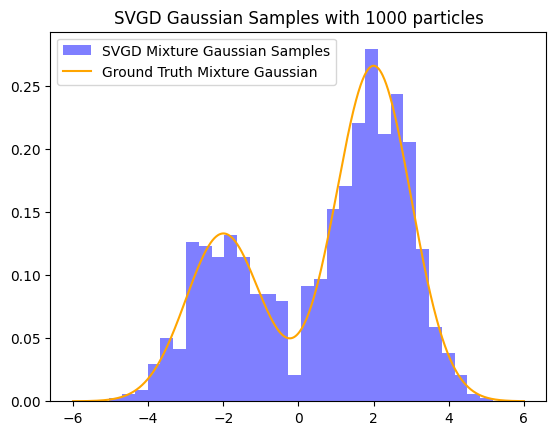

In [70]:
Mixture_Gaussian = mixtureGaussian()

n_particles=1000

x0 = np.random.normal(-10,1, [n_particles,1])
theta_gauss = SVGD().update(x0, Mixture_Gaussian.dlnprob, n_iter=1000, stepsize=0.1)

plt.hist(theta_gauss, density=True, bins=30, alpha=0.5, label='SVGD Mixture Gaussian Samples', color='blue')
plt.plot(np.linspace(-6,6,1000), Mixture_Gaussian.prob(np.linspace(-6,6,1000)), label='Ground Truth Mixture Gaussian', color='orange')
plt.legend()
plt.title(f'SVGD Gaussian Samples with {n_particles} particles')
plt.show()


Then, we compare, as in the paper, the distribution of a particule sampled through SVGD over many attemps:

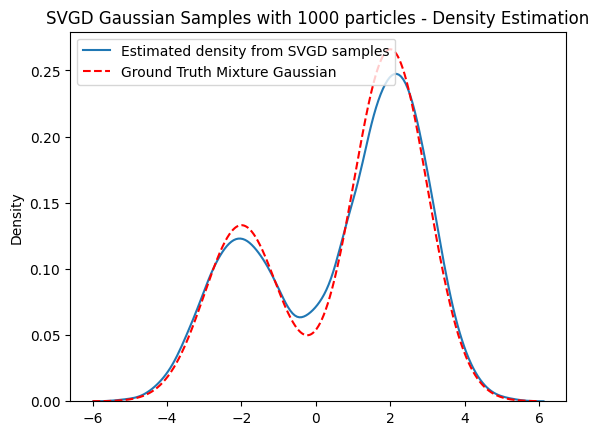

In [77]:
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

sq_dist = pdist(theta_gauss)
pairwise_dists = squareform(sq_dist)
h = np.median(pairwise_dists)  
h = h**2 / np.log(theta_gauss.shape[0]+1)

sns.kdeplot(theta_gauss, color='g',label='Estimated density from SVGD samples', bw_adjust=h)
plt.plot(np.linspace(-6,6,1000), Mixture_Gaussian.prob(np.linspace(-6,6,1000)), label='Ground Truth Mixture Gaussian', color='red', linestyle='--')
plt.legend()
plt.title(f'SVGD Gaussian Samples with {n_particles} particles - Density Estimation')
plt.show()

Finally, we calculate the estimation errors of $\mathbb{E}[h(x)]$ for $h(x)=x,x^2,cos(\omega x+b)$

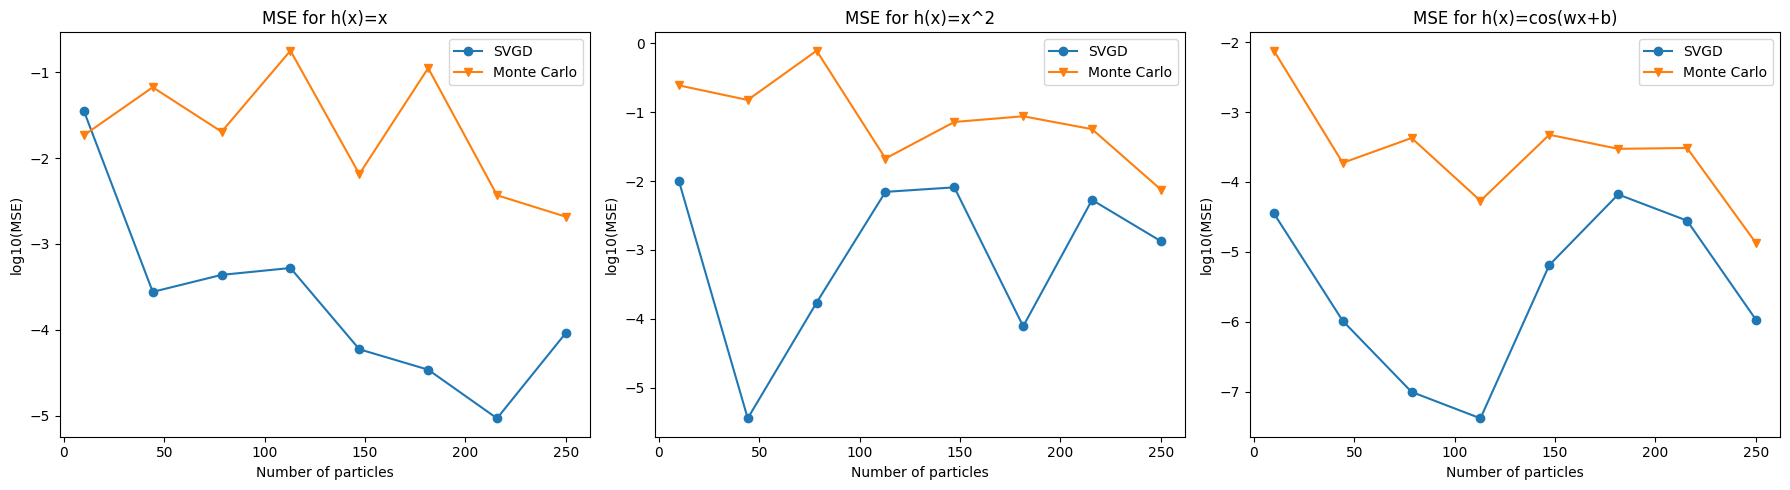

In [ ]:
n_list=np.linspace(10,250,8) # test for different number of particles

log10_MSE_SVGD=np.zeros((3, len(n_list)))
log10_MSE_MC=np.zeros((3, len(n_list)))

def direct_sampling_method(n):
    # direct sampling from the mixture Gaussian
    samples = []
    for _ in range(int(n)):
        u = random.uniform(0, 1)
        if u < 1/3:
            sample = np.random.normal(-2, 1)
        else:
            sample = np.random.normal(2, 1)
        samples.append(sample)
    return np.array(samples)


for i_n,n in enumerate(n_list) :
    x0 = np.random.normal(-10,1, [int(n),1])
    theta_gauss = SVGD().update(x0, Mixture_Gaussian.dlnprob, n_iter=2000, stepsize=0.1)
    theta_MC=direct_sampling_method(n)
    
    #h(x)=x
    log10_MSE_SVGD[0, i_n] = np.log10((np.mean(theta_gauss)-2/3)**2)
    log10_MSE_MC[0, i_n] = np.log10((np.mean(theta_MC)-2/3)**2)

    #h(x)=x^2
    log10_MSE_SVGD[1, i_n] = np.log10((np.mean(theta_gauss**2)-5)**2)
    log10_MSE_MC[1, i_n] = np.log10((np.mean(theta_MC**2)-5)**2)
    #h(x)=cos(wx+b)
    # average over 20 draws of (w,b)
    cos_estimates_error_SVGD=[]
    for _ in range(20):
        w=random.uniform(0,5)
        b=random.uniform(0,2*np.pi)
        cos_estimates_error_SVGD.append(np.mean(np.cos(w*theta_gauss + b))-(1/3)*np.exp(-0.5*(w**2)) * np.cos(b + w*(-2)) - (2/3)*np.exp(-0.5*(w**2)) * np.cos(b + w*(2)))
    log10_MSE_SVGD[2, i_n] = np.log10((np.mean(cos_estimates_error_SVGD))**2)
    
    cos_estimates_error_MC=[]
    for _ in range(20):
        w=random.uniform(0,5)
        b=random.uniform(0,2*np.pi)
        cos_estimates_error_MC.append(np.mean(np.cos(w*theta_MC + b))-(1/3)*np.exp(-0.5*(w**2)) * np.cos(b + w*(-2)) - (2/3)*np.exp(-0.5*(w**2)) * np.cos(b + w*(2)))
    log10_MSE_MC[2, i_n] = np.log10((np.mean(cos_estimates_error_MC))**2)

#now, we plot the errors (1 plot per function g)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].plot(n_list, log10_MSE_SVGD[0, :], label='SVGD', marker='o')
axs[0].plot(n_list, log10_MSE_MC[0, :], label='Monte Carlo', marker='v')
axs[0].set_title('MSE for h(x)=x')
axs[0].set_xlabel('Number of particles')
axs[0].set_ylabel('log10(MSE)')
axs[0].legend()

axs[1].plot(n_list, log10_MSE_SVGD[1, :], label='SVGD', marker='o')
axs[1].plot(n_list, log10_MSE_MC[1, :], label='Monte Carlo', marker='v')
axs[1].set_title('MSE for h(x)=x^2')
axs[1].set_xlabel('Number of particles')
axs[1].set_ylabel('log10(MSE)')
axs[1].legend()

axs[2].plot(n_list, log10_MSE_SVGD[2, :], label='SVGD', marker='o')
axs[2].plot(n_list, log10_MSE_MC[2, :], label='Monte Carlo', marker='v')
axs[2].set_title('MSE for h(x)=cos(wx+b)')
axs[2].set_xlabel('Number of particles')
axs[2].set_ylabel('log10(MSE)')
axs[2].legend()

plt.tight_layout()
plt.show()
    

Then, we test the same procedure for a cauchy distribution:

In [37]:
class Cauchy:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def prob(self, x):
        return 1 / (np.pi * self.sigma * (1 + ((x - self.mu) / self.sigma) ** 2))

    def dlnprob(self, theta):
        return -1*(2/self.sigma)*((theta-self.mu)/(1+((theta - self.mu) / self.sigma) ** 2))


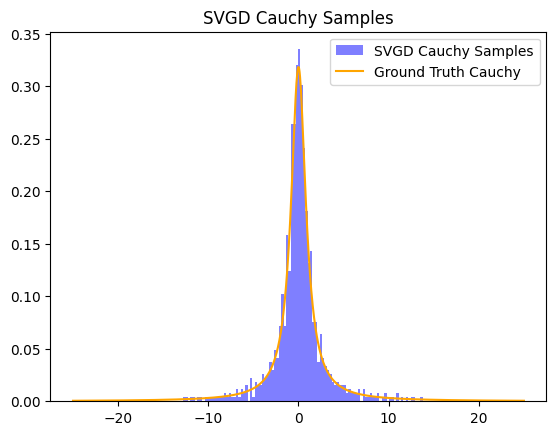

In [67]:
mu_cauchy, sigma_cauchy = 0, 1
Cauchy_model = Cauchy(mu_cauchy, sigma_cauchy)


n_particles=1000

x0 = np.random.normal(0,1, [n_particles,1])

theta_cauchy = SVGD().update(x0, Cauchy_model.dlnprob, n_iter=1000, stepsize=0.01)


plt.hist(theta_cauchy, density=True, bins=100, alpha=0.5, label='SVGD Cauchy Samples', color='blue')
plt.plot(np.linspace(-25,25,1000), Cauchy_model.prob(np.linspace(-25,25,1000)), label='Ground Truth Cauchy', color='orange')
plt.legend()
plt.title('SVGD Cauchy Samples')
plt.show()

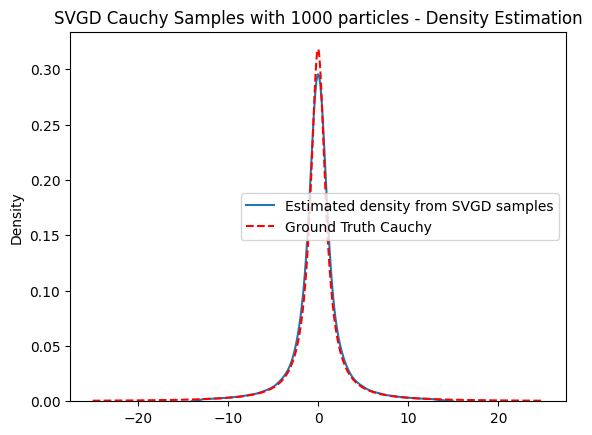

In [78]:
import seaborn as sns
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

sq_dist = pdist(theta_gauss)
pairwise_dists = squareform(sq_dist)
h = np.median(pairwise_dists)  
h = h**2 / np.log(theta_gauss.shape[0]+1)

sns.kdeplot(theta_cauchy, color='g',label='Estimated density from SVGD samples', bw_adjust=h)
plt.plot(np.linspace(-25,25,1000), Cauchy_model.prob(np.linspace(-25,25,1000)), label='Ground Truth Cauchy', color='red', linestyle='--')
plt.legend()
plt.title(f'SVGD Cauchy Samples with {n_particles} particles - Density Estimation')
plt.show()